In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from loader import get_train_loader
import time

In [2]:
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, padding=0),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=2, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [3]:
autoencoder_people = torch.load('autoencoder.people.4.pt')

In [4]:
autoencoder_stickmans = torch.load('autoencoder.stickmen.4.pt')

In [5]:
dim_x = 8
batch_size = 64
train_loader, val_loader = get_train_loader("../deepfashion/index.p", batch_size=batch_size, resize_size=8)

In [91]:
class Net4Group2(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """

    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net4Group2, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(48, 64, 1, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        return x

In [353]:
mask_input_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 ==0:
                    mask_input_1[m][n][i][j] = True

In [354]:
mask_output_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 1:
                    mask_output_1[m][n][i][j] = True

In [94]:
criterion = torch.nn.MSELoss()
net4_group2 = Net4Group2().cuda()
optimizer = optim.Adam(net4_group2.parameters(), lr=1e-3)

In [95]:
def train_network(net, criterion, optimizer, mask_input, mask_output, shape_input, shape_output, num_epochs):
    train_loss = []
    val_loss = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True)
        i = 0
        for X_batch, y_batch in train_loader:
            i += 1
            if X_batch.shape[0] != batch_size:
                continue
            X_batch_input = X_batch[:, 0]
            X_batch_input = X_batch_input[mask_input.nonzero()].view(shape_input)
            X_batch_input = Variable(X_batch_input).cuda()

            X_batch_output = X_batch[:, 1]
            X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
            X_batch_output = Variable(X_batch_output).cuda()

            output_img = net(X_batch_input,
                                     keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                                     embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1])
            loss = criterion(output_img, X_batch_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        # And a full pass over the validation data:
    #     autoencoder.train(False) # disable dropout / use averages for batch_norm
    #     for X_batch, y_batch in val_loader:
    #         X_batch_0 = Variable(y_batch[:, 0]).cuda()
    #         output_img, _ = autoencoder(X_batch_0)
    #         val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
    #         X_batch_1 = Variable(y_batch[:, 1]).cuda()
    #         output_img, _ = autoencoder(X_batch_1)
    #         val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])

        print 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-2 * len(train_loader):])))
    #     print("  validation loss: \t\t\t{:.6f}".format(
    #         np.mean(val_loss[-2 * len(val_loader):])))

In [96]:
train_network(net4_group2, criterion, optimizer, mask_input_1, mask_output_1,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 45.934s
  training loss (in-iteration): 	0.018011
Epoch 2 of 100 took 44.553s
  training loss (in-iteration): 	0.012722
Epoch 3 of 100 took 44.233s
  training loss (in-iteration): 	0.007005
Epoch 4 of 100 took 44.253s
  training loss (in-iteration): 	0.006341
Epoch 5 of 100 took 44.978s
  training loss (in-iteration): 	0.005992
Epoch 6 of 100 took 42.923s
  training loss (in-iteration): 	0.005762
Epoch 7 of 100 took 42.849s
  training loss (in-iteration): 	0.005590
Epoch 8 of 100 took 43.588s
  training loss (in-iteration): 	0.005446
Epoch 9 of 100 took 44.872s
  training loss (in-iteration): 	0.005321
Epoch 10 of 100 took 45.248s
  training loss (in-iteration): 	0.005213
Epoch 11 of 100 took 45.352s
  training loss (in-iteration): 	0.005118
Epoch 12 of 100 took 43.590s
  training loss (in-iteration): 	0.005033
Epoch 13 of 100 took 48.816s
  training loss (in-iteration): 	0.004957
Epoch 14 of 100 took 50.339s
  training loss (in-iteration): 	0.004889
Epoch 15 of 100

In [113]:
torch.save(net4_group2, "net4.group2.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net4Group2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [97]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    scale_const = 1.2
    plt.figure(figsize=(3 / scale_const * n_col, 3.4 / scale_const * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].numpy().transpose(1,2,0), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [98]:
for X_batch, y_batch in train_loader:
    break

In [104]:
X_batch_input = X_batch[:, 0]
X_batch_input = X_batch_input[mask_input.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
X_batch_input = Variable(X_batch_input).cuda()

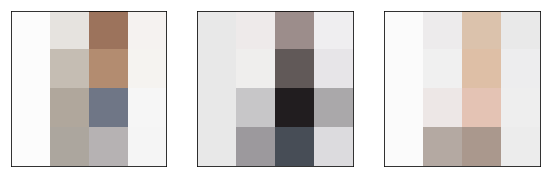

In [110]:
plot_gallery(X_batch_input.cpu().data, 8, 8, 1, 3)

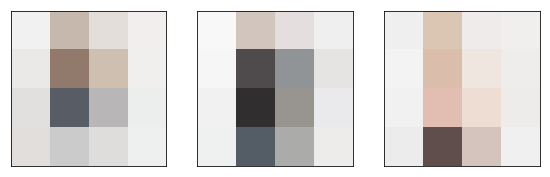

In [108]:
plot_gallery(net4_group2(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data,
             8, 8, 1, 3)

In [111]:
X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

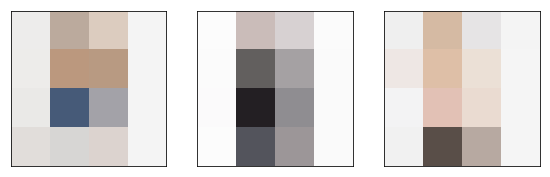

In [112]:
plot_gallery(X_batch_output, 8, 8, 1, 3)

In [296]:
class Net4Group3(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """
    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net4Group3, self).__init__()
        
        self.first_part = nn.Sequential(
            
            nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=(1, 3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(inplace=True)
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(48, 64, 1, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
#         print(x.shape)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        return x

In [294]:
# class Net4Group3(nn.Module):
#     """
#         Network for predictions group 2 images based on group 1.
#         input size: 4x4
#         output size: 4x4
#     """
#     def __init__(self, layers=[1], bottelneck_size=32):
#         super(Net4Group3, self).__init__()
        
#         self.first_part = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=2),
#             nn.MaxPool2d((1, 2)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True)
#         )

#         self.up_1 = nn.Sequential(
#             nn.ConvTranspose2d(48, 64, 1, stride=2)
#         )

#         self.conv_1 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
#             nn.Sigmoid()
#         )

#     def forward(self, x, keypoints, embeddings):
# #         print(x.shape)
#         x = self.first_part(x)
# #         print(x.shape)
#         x = torch.cat((x, keypoints, embeddings), dim=1)
#         x = self.up_1(x)
#         x = self.conv_1(x)
#         return x

In [364]:
mask_input_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0:
                    mask_input_2[m][n][i][j] = True

In [365]:
mask_output_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 0:
                    mask_output_2[m][n][i][j] = True

In [299]:
criterion = torch.nn.MSELoss()
net4_group3 = Net4Group3().cuda()
optimizer = optim.Adam(net4_group3.parameters(), lr=1e-3)

In [ ]:
train_network(net4_group3, criterion, optimizer, mask_input, mask_output,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 43.915s
  training loss (in-iteration): 	0.016668
Epoch 2 of 100 took 43.274s
  training loss (in-iteration): 	0.012164
Epoch 3 of 100 took 43.242s
  training loss (in-iteration): 	0.007289
Epoch 4 of 100 took 43.849s
  training loss (in-iteration): 	0.006705
Epoch 5 of 100 took 43.894s
  training loss (in-iteration): 	0.006379
Epoch 6 of 100 took 43.236s
  training loss (in-iteration): 	0.006155
Epoch 7 of 100 took 44.300s
  training loss (in-iteration): 	0.005981
Epoch 8 of 100 took 44.871s
  training loss (in-iteration): 	0.005840
Epoch 9 of 100 took 43.848s
  training loss (in-iteration): 	0.005720
Epoch 10 of 100 took 43.909s
  training loss (in-iteration): 	0.005613
Epoch 11 of 100 took 45.354s
  training loss (in-iteration): 	0.005518
Epoch 12 of 100 took 44.739s
  training loss (in-iteration): 	0.005432
Epoch 13 of 100 took 43.520s
  training loss (in-iteration): 	0.005351
Epoch 14 of 100 took 43.197s
  training loss (in-iteration): 	0.005277
Epoch 15 of 100

In [302]:
train_network(net4_group3, criterion, optimizer, mask_input, mask_output,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=1
             )

Epoch 1 of 1 took 44.164s
  training loss (in-iteration): 	0.003142


In [303]:
torch.save(net4_group3, "net4.group3.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net4Group3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


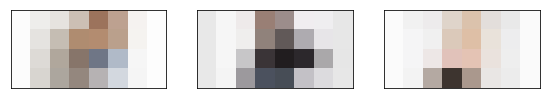

In [305]:
X_batch_input = X_batch[:, 0]
X_batch_input = X_batch_input[mask_input.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x)))
X_batch_input = Variable(X_batch_input).cuda()
plot_gallery(X_batch_input.cpu().data, 8, 8, 1, 3)

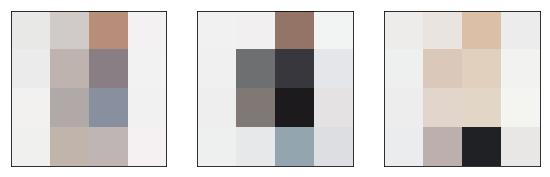

In [306]:
plot_gallery(net4_group3(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data,
             8, 8, 1, 3)

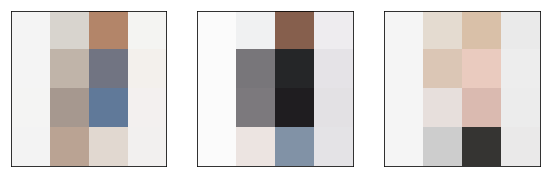

In [307]:
X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
plot_gallery(X_batch_output, 8, 8, 1, 3)

In [319]:
def train_group4_network(net, criterion, optimizer, mask_input, mask_output, shape_output, num_epochs):
    train_loss = []
    val_loss = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True)
        i = 0
        for X_batch, y_batch in train_loader:
            i += 1
            if X_batch.shape[0] != batch_size:
                continue
            X_batch_input = X_batch[:, 0]
            X_batch_input[(~mask_input).nonzero()] = 0
            X_batch_input = Variable(X_batch_input).cuda()

            X_batch_output = X_batch[:, 1]
            X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
            X_batch_output = Variable(X_batch_output).cuda()

            output_img = net(X_batch_input,
                                     keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                                     embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1])
            loss = criterion(output_img, X_batch_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        # And a full pass over the validation data:
    #     autoencoder.train(False) # disable dropout / use averages for batch_norm
    #     for X_batch, y_batch in val_loader:
    #         X_batch_0 = Variable(y_batch[:, 0]).cuda()
    #         output_img, _ = autoencoder(X_batch_0)
    #         val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
    #         X_batch_1 = Variable(y_batch[:, 1]).cuda()
    #         output_img, _ = autoencoder(X_batch_1)
    #         val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])

        print 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-2 * len(train_loader):])))
    #     print("  validation loss: \t\t\t{:.6f}".format(
    #         np.mean(val_loss[-2 * len(val_loader):])))

In [340]:
class Net4Group4(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """

    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net4Group4, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            
            nn.ReLU(inplace=True),
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 1, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        return x

In [362]:
mask_input_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 or j % 2 == 0:
                    mask_input_3[m][n][i][j] = True

In [363]:
mask_output_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 1:
                    mask_output_3[m][n][i][j] = True

In [343]:
criterion = torch.nn.MSELoss()
net4_group4 = Net4Group4().cuda()
optimizer = optim.Adam(net4_group4.parameters(), lr=1e-3)

In [344]:
train_group4_network(net4_group4, criterion, optimizer, mask_input_3, mask_output_3,
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 42.841s
  training loss (in-iteration): 	0.015678
Epoch 2 of 100 took 43.864s
  training loss (in-iteration): 	0.011817
Epoch 3 of 100 took 45.041s
  training loss (in-iteration): 	0.007518
Epoch 4 of 100 took 44.261s
  training loss (in-iteration): 	0.006845
Epoch 5 of 100 took 42.551s
  training loss (in-iteration): 	0.006491
Epoch 6 of 100 took 42.373s
  training loss (in-iteration): 	0.006247
Epoch 7 of 100 took 43.562s
  training loss (in-iteration): 	0.006060
Epoch 8 of 100 took 43.679s
  training loss (in-iteration): 	0.005906
Epoch 9 of 100 took 43.410s
  training loss (in-iteration): 	0.005773
Epoch 10 of 100 took 44.620s
  training loss (in-iteration): 	0.005650
Epoch 11 of 100 took 42.912s
  training loss (in-iteration): 	0.005543
Epoch 12 of 100 took 44.131s
  training loss (in-iteration): 	0.005446
Epoch 13 of 100 took 43.266s
  training loss (in-iteration): 	0.005356
Epoch 14 of 100 took 44.248s
  training loss (in-iteration): 	0.005278
Epoch 15 of 100

In [345]:
torch.save(net4_group4, "net4.group4.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net4Group4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


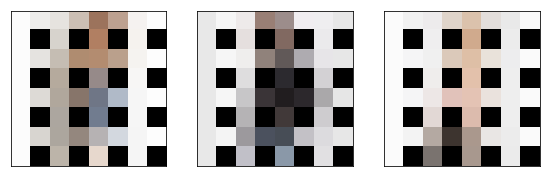

In [347]:
X_batch_input = X_batch[:, 0].clone()
X_batch_input[(~mask_input_3).nonzero()] = 0
X_batch_input = Variable(X_batch_input).cuda()
plot_gallery(X_batch_input.cpu().data, 8, 8, 1, 3)

In [357]:
mask_group_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 0:
                    mask_group_1[m][n][i][j] = True

mask_group_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 1:
                    mask_group_2[m][n][i][j] = True

mask_group_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 0:
                    mask_group_3[m][n][i][j] = True

mask_group_4 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 1:
                    mask_group_4[m][n][i][j] = True

In [404]:
def convert_input_into_image(X_batch):
    X_batch_input = X_batch[:, 0].clone()
    X_batch_input = X_batch_input[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_1 = X_batch_input
    group_2 = net4_group2(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    X_batch_input = X_batch[:, 0].clone()
    X_batch_input = X_batch_input[mask_input_2.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x)))
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_3 = net4_group3(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    X_batch_input = X_batch[:, 0].clone()
    X_batch_input[(~mask_input_3).nonzero()] = 0
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_4 = net4_group4(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    final_image = torch.zeros_like(X_batch[:, 1]).double()
    final_image[mask_group_1.nonzero()] = group_1.view(-1).cpu().data.double()
    final_image[mask_group_2.nonzero()] = group_2.view(-1).double()
    final_image[mask_group_3.nonzero()] = group_3.view(-1).double()
    final_image[mask_group_4.nonzero()] = group_4.view(-1).double()
    
    plot_gallery(X_batch[:, 1], 8, 8, 1, 3)
    plot_gallery(final_image, 8, 8, 1, 3)

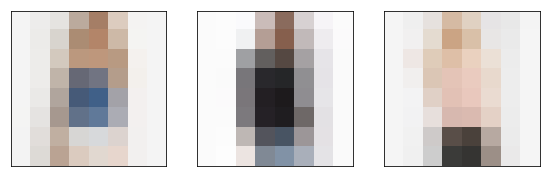

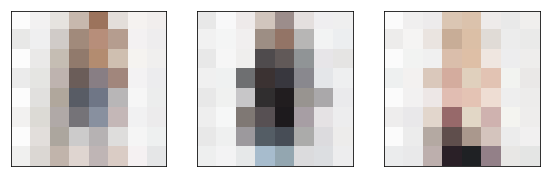

In [405]:
convert_input_into_image(X_batch)

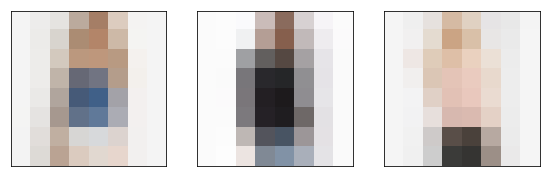

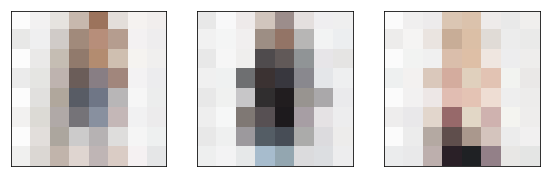

In [402]:
convert_input_into_image(X_batch)

In [400]:
for X_batch, y_batch in train_loader:
    break

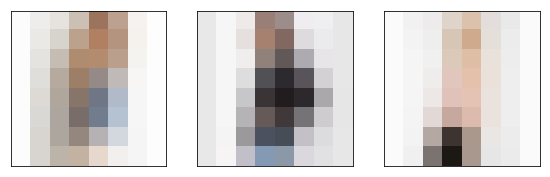

In [403]:
plot_gallery(X_batch[:, 0], 8, 8, 1, 3)

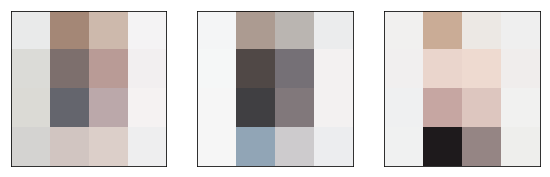

In [349]:
plot_gallery(net4_group4(X_batch_input,
                 keypoints=autoencoder_stickmans(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people(Variable(X_batch[:, 0]).cuda())[1]).cpu().data,
             8, 8, 1, 3)

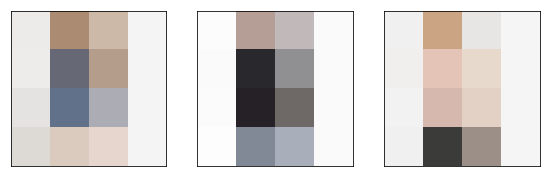

In [350]:
X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
plot_gallery(X_batch_output, 8, 8, 1, 3)